In [1]:
%matplotlib inline
import backtrader as bt
import backtrader.indicators as btind
import backtrader.feeds as btfeeds
import datetime
import matplotlib
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

In [2]:
class MACD(bt.Strategy):
    params = (
        ('macd1', 12),
        ('macd2', 26),
        ('sigp', 9)
    )

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.dataclose = self.datas[0].close

        self.order = None
        self.buyprice = None
        self.buycomm = None

        self.macd = btind.MACD(
            self.data, period_me1=self.p.macd1, period_me2=self.p.macd2, period_signal = self.p.sigp)
        self.crossovr = btind.CrossOver(self.macd.macd, self.macd.signal)
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        if self.order:
            return
        if not self.position:
            if self.crossovr > 0:
                self.log('BUY CREATE, %.2f' % self.data.close[0])
                self.order = self.buy()
            elif self.crossovr < 0:
                self.log('SELL CREATE, %.2f' % self.data.close[0])
                self.order = self.sell()
        else:
            if self.getposition(data=self.data).size > 0 and self.crossovr < 0:
                self.log('Long ended, %.2f' % self.data.close[0])
                self.order = self.close()
            elif self.getposition(data=self.data).size<0 and self.crossovr > 0:
                self.log('Short ended, %.2f' % self.data.close[0])  
                self.order = self.close()

In [3]:
cerebro = bt.Cerebro()
data = btfeeds.YahooFinanceCSVData(
        dataname = '../data/yhoo-1996-2014.txt',
        fromdate=datetime.datetime(2004, 1, 1),
        todate=datetime.datetime(2008, 12, 31),
        reverse=False
    )

In [4]:
cerebro.adddata(data)
cerebro.addstrategy(MACD)
cerebro.broker.setcash(100000.0)  
cerebro.broker.setcommission(commission=0.01)
start_portfolio_value = cerebro.broker.getvalue()

In [5]:
cerebro.run()
end_portfolio_value = cerebro.broker.getvalue()
print("Starting portfolio value: %s \nEnding portfolio value: %s \nProfit: %s" \
          %(start_portfolio_value,end_portfolio_value,end_portfolio_value-start_portfolio_value))

2004-02-23, SELL CREATE, 22.45
2004-02-24, SELL EXECUTED, Price: 22.43, Cost: -22.43, Comm 0.22
2004-03-17, Short ended, 22.42
2004-03-18, BUY EXECUTED, Price: 22.39, Cost: -22.43, Comm 0.22
2004-03-18, OPERATION PROFIT, GROSS 0.04, NET -0.41
2004-04-29, SELL CREATE, 27.36
2004-04-30, SELL EXECUTED, Price: 27.20, Cost: -27.20, Comm 0.27
2004-05-19, Short ended, 27.95
2004-05-20, BUY EXECUTED, Price: 28.12, Cost: -27.20, Comm 0.28
2004-05-20, OPERATION PROFIT, GROSS -0.92, NET -1.47
2004-06-15, SELL CREATE, 32.10
2004-06-16, SELL EXECUTED, Price: 32.41, Cost: -32.41, Comm 0.32
2004-06-24, Short ended, 34.11
2004-06-25, BUY EXECUTED, Price: 34.37, Cost: -32.41, Comm 0.34
2004-06-25, OPERATION PROFIT, GROSS -1.96, NET -2.63
2004-07-02, SELL CREATE, 33.94
2004-07-06, SELL EXECUTED, Price: 34.00, Cost: -34.00, Comm 0.34
2004-07-29, Short ended, 30.49
2004-07-30, BUY EXECUTED, Price: 30.25, Cost: -34.00, Comm 0.30
2004-07-30, OPERATION PROFIT, GROSS 3.75, NET 3.11
2004-08-04, SELL CREATE, 27

<IPython.core.display.Javascript object>


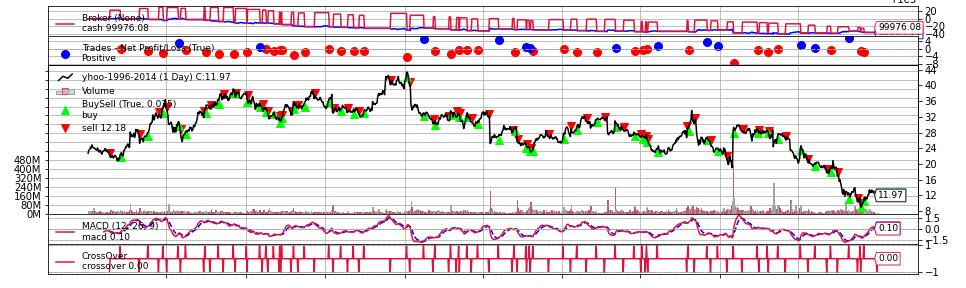

[[<Figure size 432x288 with 6 Axes>]]

In [6]:
cerebro.plot()